##  Predicting business users from private parking users

Predict which private users are parking for business purposes based on their parking behavior. 

Approach: After some basic EDA, we have both corporate and private users. Using corporate data, I tried to find patterns in it that specifies their parking behavior e.g. finding specific zones via location in which they park and corporate hours. Based on that, I created is_business_like label and converted it into a classification problem. Also used KMeans clustering to find business zones.

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None) # to show all columns
pd.set_option('display.max_rows', None) # to show all rows

2024-11-27 23:51:54,243 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-27 23:51:54,251 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


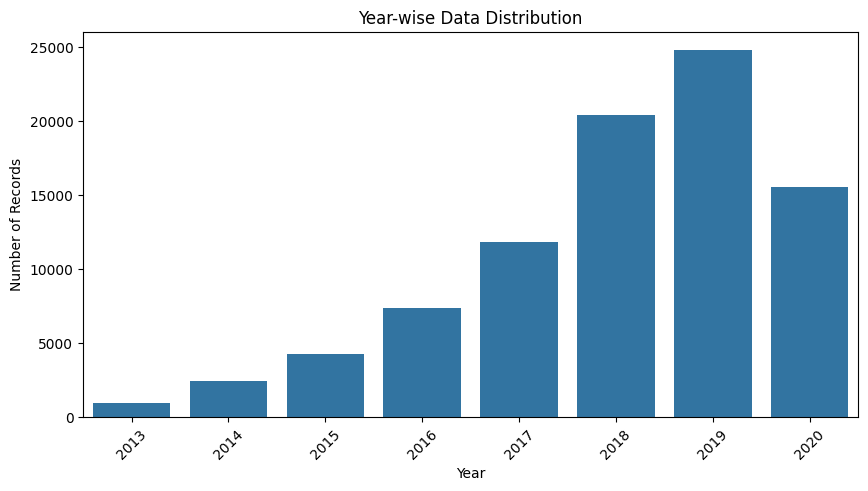

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv("assignment-sample-data.csv")

# Convert date columns to datetime
data['parking_start_time'] = pd.to_datetime(data['parking_start_time'])
data['parking_end_time'] = pd.to_datetime(data['parking_end_time'])

# Extract the year from 'parking_start_time'
data['year'] = data['parking_start_time'].dt.year

# Count the occurrences of each year
year_counts = data['year'].value_counts().sort_index()

# Explicitly convert the index and values to Python lists
years = list(year_counts.index)  # Convert to plain Python list
counts = list(year_counts.values)  # Convert to plain Python list

# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=years, y=counts)

# Add titles and labels
plt.title('Year-wise Data Distribution')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [ ]:
import logging
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def eda(data,train_data):
    """
    # Function for exploratory data analysis (EDA) including plots

    Args:
    - data (pd.DataFrame): Data in CSV file.
    - train_data (pd.DataFrame): The training dataset.
    
    Returns:
        None
    """ 
    # Check for missing values
    logging.info(f"Total Missing Values: {data.isnull().sum().sum()}")
    
    # Plot business zones
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='lat', y='lon', hue='business_zone', data=train_data,
        palette='tab10', alpha=0.7
    )
    plt.title('Business Zones Clusters')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend(title='Business Zone')
    plt.show()  

    # Plot start_hour distribution
    plt.figure(figsize=(10, 5))
    plt.hist(data['start_hour'], bins=24, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Start Hour')
    plt.xlabel('Hour of Day (0-23)')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 24))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot end_hour distribution
    plt.figure(figsize=(10, 5))
    plt.hist(data['end_hour'], bins=24, color='green', alpha=0.7, edgecolor='black')
    plt.title('Distribution of End Hour')
    plt.xlabel('Hour of Day (0-23)')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 24))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Plot day_of_week distribution
    plt.figure(figsize=(10, 5))
    plt.hist(data['day_of_week'], bins=24, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Day of week')
    plt.xlabel('Day of week (0-6)')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 7))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Plot yearly distribution
    plt.figure(figsize=(10, 5))
    data['year'] = data['parking_start_time'].dt.year
    year_counts = data['year'].value_counts().sort_index()
    sns.barplot(x=year_counts.index, y=year_counts.values, palette='viridis', hue=year_counts.index,legend=False)
    plt.title('Year-wise Data Distribution')
    plt.xlabel('Year')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45)
    plt.show()



def load_data(file_path):
    """
    Load and preprocess data from the provided CSV file.
    
    Args:
    - file_path (str): Path to the CSV file.
    
    Returns:
    - pd.DataFrame: The preprocessed dataframe.
    """
    try:
        data = pd.read_csv(file_path)
        logging.info(f"Data in csv shape: {data.shape}")
        data['parking_start_time'] = pd.to_datetime(data['parking_start_time'])
        data['parking_end_time'] = pd.to_datetime(data['parking_end_time'])
        
        # Display unique values in categorical columns
        logging.info(f"Unique values in loaded data")
        categorical_columns = data.select_dtypes(include=['object']).columns
        for column in categorical_columns:
            unique_values = data[column].unique()
            logging.info(f"Unique values in '{column}': {unique_values}")
        logging.info(f"Data loaded successfully from {file_path}.")
        return data
    
    except Exception as e:
        logging.error(f"Error loading data from {file_path}: {e}")
        raise

def feature_engineering_and_data_cleaning(data):
    """
    Perform feature engineering on the dataset.
    
    Args:
    - data (pd.DataFrame): The input dataframe.
    
    Returns:
    - pd.DataFrame: The dataframe with new features.
    """
    try:
        data['parking_duration_mins'] = (data['parking_end_time'] - data['parking_start_time']).dt.total_seconds() / 60
        data['start_hour'] = data['parking_start_time'].dt.hour
        data['end_hour'] = data['parking_end_time'].dt.hour
        data['day_of_week'] = data['parking_start_time'].dt.dayofweek
        data['user_parking_count'] = data.groupby('parkinguser_id')['parking_id'].transform('count')
        
        # Cleaning: Filter out invalid coordinates
        data = data[(data['lat'] > -90) & (data['lat'] < 90) & (data['lon'] > -180) & (data['lon'] < 180)]
        
        # Cleaning: Filter out invalid time ranges
        data = data[(data['start_hour'] >= 0) & (data['start_hour'] <= 24)]
        data = data[(data['end_hour'] >= 0) & (data['end_hour'] <= 24)]
        
        logging.info("Feature engineering completed successfully.")
        return data
    
    except Exception as e:
        logging.error(f"Error in feature engineering: {e}")
        raise

def split_data(data):
    """
    Split the data into training and testing sets.
    
    Args:
    - data (pd.DataFrame): The input dataframe.
    
    Returns:
    - pd.DataFrame, pd.DataFrame: Training and testing datasets.
    """
    try:
        train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['account_type_private'])
        logging.info(f"Data split into train and test sets. Train shape: {train_data.shape}, Test shape: {test_data.shape}")
        return train_data, test_data
    
    except Exception as e:
        logging.error(f"Error splitting data: {e}")
        raise

def apply_one_hot_encoding(data):
    """
    Apply one-hot encoding to categorical columns of the dataset.
    
    Args:
    - data (pd.DataFrame): The dataset.
    
    Returns:
    - pd.DataFrame: One-hot encoded datasets.
    """
    try:
        categorical_columns = data.select_dtypes(include=['object']).columns
        data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
        logging.info("One-hot encoding applied successfully.")
        return data
    
    except Exception as e:
        logging.error(f"Error applying one-hot encoding: {e}")
        raise

def process_corporate_data(data, corporate_data):
    """
    Process the corporate data, apply KMeans clustering, and identify corporate hours.
    
    Args:
    - data (pd.DataFrame): The dataset.
    - corporate_data (pd.DataFrame): The corporate data subset.
    
    Returns:
    - pd.DataFrame: Updated datasets with business zone and corporate hour features.
    """
    try:
        if not corporate_data.empty:
            logging.info(f"Deducing patterns from corporate data with shape: {corporate_data.shape}")
         
            # Spatial behaviors: Do corporate users park in specific geographical zones?
            corporate_locations = corporate_data[['lat', 'lon']]
            kmeans = KMeans(n_clusters=5, random_state=42).fit(corporate_locations)

            # Compute distances to cluster centroids for train data
            distances_to_centroids = kmeans.transform(data[['lat', 'lon']])
            min_distances = distances_to_centroids.min(axis=1)

            # Define a threshold for outlier detection (e.g., 90th percentile)
            distance_threshold = np.percentile(min_distances, 90)

            # Assign business zones or 'Other Cluster'
            data['business_zone'] = np.where(
                min_distances <= distance_threshold, 
                kmeans.predict(data[['lat', 'lon']]),
                -1  # -1 for 'Other Cluster'
            )
            
            # Temporal behaviors: Do corporate users park in specific hours?
            # Process corporate hours
            corporate_data['hour'] = corporate_data['parking_start_time'].dt.hour
            corporate_hours = corporate_data.groupby('hour').size().sort_values(ascending=False).head(3).index
            logging.info(f"Top 3 corporate hours are: {corporate_hours}")
            
            data['is_corporate_hour'] = data['parking_start_time'].dt.hour.isin(corporate_hours).astype(int)
        else:
            logging.warning("No corporate data found in the dataset.")
            data['business_zone'] = -1
            data['is_corporate_hour'] = 0
        return data
    
    except Exception as e:
        logging.error(f"Error processing corporate data: {e}")
        raise

def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    """
    Train and evaluate the RandomForestClassifier model.
    
    Args:
    - X_train (pd.DataFrame): The training features.
    - y_train (pd.Series): The training target.
    - X_test (pd.DataFrame): The test features.
    - y_test (pd.Series): The test target.
    
    Returns:
    - RandomForestClassifier: The trained model.
    """
    try:
        # Apply SMOTE to balance classes
        logging.info("Train dataset class label is_business_like distribution: {}".format(Counter(y_train)))
        
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        logging.info("SMOTE applied to majority class. Class distribution after resampling: {}".format(Counter(y_train_resampled)))
        
        # Initialize the pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier(random_state=42))
        ])
        
        # Perform cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=cv, scoring='f1')
        logging.info(f"Cross-validation F1 scores: {cv_scores}")
        
        # Train the model
        pipeline.fit(X_train_resampled, y_train_resampled)
        
        # Predictions and evaluation
        y_pred = pipeline.predict(X_test)
        report = classification_report(y_test, y_pred)
        logging.info(f"Classification Report on test set:\n{report}")
        
        # Save the trained model
        joblib.dump(pipeline, 'business_parking_model.pkl')
        logging.info("Model saved successfully.")
        
        return pipeline
    
    except Exception as e:
        logging.error(f"Error during model training and evaluation: {e}")
        raise

def main():
    try:
        # Load and preprocess data
        data = load_data('assignment-sample-data.csv')
        data = feature_engineering_and_data_cleaning(data)
        
        # Separate corporate data for specific processing
        corporate_data = data[data['account_type'] == 'corporate'].copy()
        
        # Apply one-hot encoding
        data = apply_one_hot_encoding(data)
        
        # Process corporate data
        data = process_corporate_data(data, corporate_data)
        
        # Split data into train and test
        train_data, test_data = split_data(data)
        
        # Some plotting for EDA
        eda(data, train_data)
        
        # Prepare training features and target
        features = ['parking_fee', 'parking_duration_mins', 'end_hour', 'day_of_week', 'user_parking_count']
        private_train_data = train_data[train_data['account_type_private'] == 1].copy()
        logging.info(f"Private train data shape for model: {private_train_data.shape}")
        
        
        # 'is_business_like' to exclude outliers (-1) from business zones
        private_train_data['is_business_like'] = (
            (private_train_data['business_zone'] != -1) &  # Exclude outliers
            (private_train_data['is_corporate_hour'] == 1)
        ).astype(int)
        
        X_train = private_train_data[features]
        y_train = private_train_data['is_business_like']
        
        # Prepare test features and target
        private_test_data = test_data[test_data['account_type_private'] == 1].copy()
        logging.info(f"Private test data shape for model: {private_test_data.shape}")
        
        private_test_data['is_business_like'] = (
            (private_test_data['business_zone'] != -1) &  # Exclude outliers
            (private_test_data['is_corporate_hour'] == 1)
        ).astype(int)
        
        X_test = private_test_data[features]
        y_test = private_test_data['is_business_like']
        
        # Train and evaluate model
        train_and_evaluate_model(X_train, y_train, X_test, y_test)
        
    except Exception as e:
        logging.error(f"Error in main execution: {e}")

if __name__ == "__main__":
    main()

SyntaxError: keyword argument repeated: x (1812382982.py, line 80)